In [1]:
import segmentation
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import nibabel as nib
import SimpleITK as sitk
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import time

## Run once for creating masks

In [2]:
segmentation.create_masks()

100%|██████████| 5/5 [00:00<00:00, 46.07it/s]


100%|██████████| 5/5 [00:00<00:00, 64.85it/s]


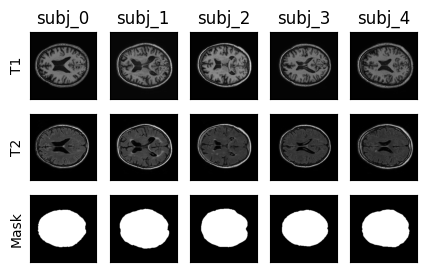

In [3]:
fig, ax = plt.subplots(3, 5, figsize=(5, 3))

layer = 25 
  
for i in tqdm(range(5)):
    t1 = nib.load(os.path.join('..','P2_Data',f'{i}','T1.nii')).get_fdata()
    t2 = nib.load(os.path.join('..','P2_Data',f'{i}','T2_FLAIR.nii')).get_fdata()
    bm = nib.load(os.path.join('..','P2_Data',f'{i}','brainMask.nii')).get_fdata()
        
    titles = ['T1', 'T2', 'Mask']
    for k, img in enumerate([t1, t2, bm]):
            if k == 0:
                ax[k, i].set_title(f'subj_{i}')
            ax[k, i].set_xticks([])
            ax[k, i].set_yticks([])
            if i == 0:
                ax[k, i].set_ylabel(titles[k])
            ax[k, i].imshow(img[:, :, layer], cmap='gray')
            
plt.show()

------------ Subject 0---------------------


 74%|███████▍  | 74/100 [00:15<00:05,  4.83it/s]


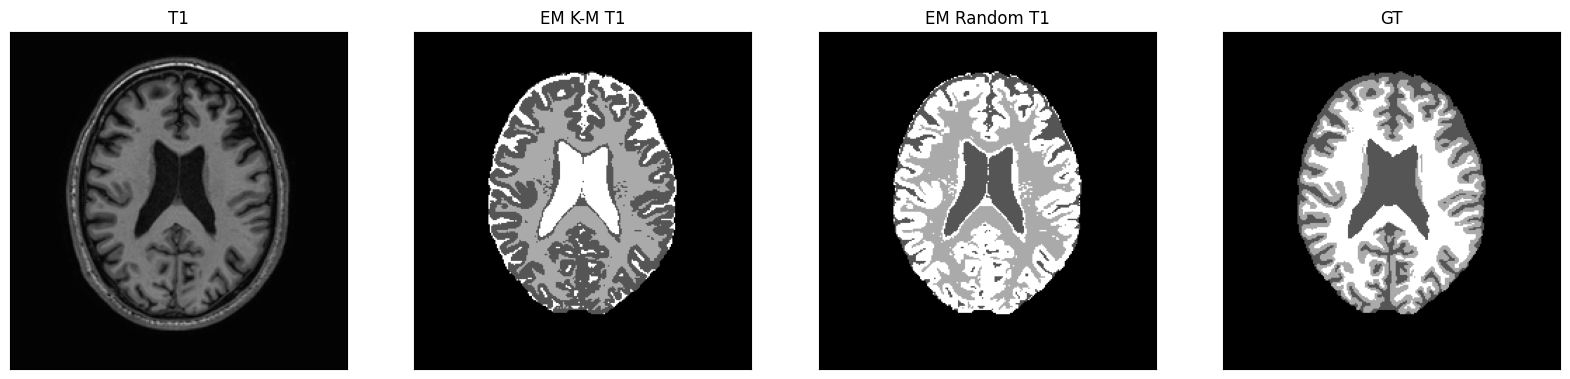

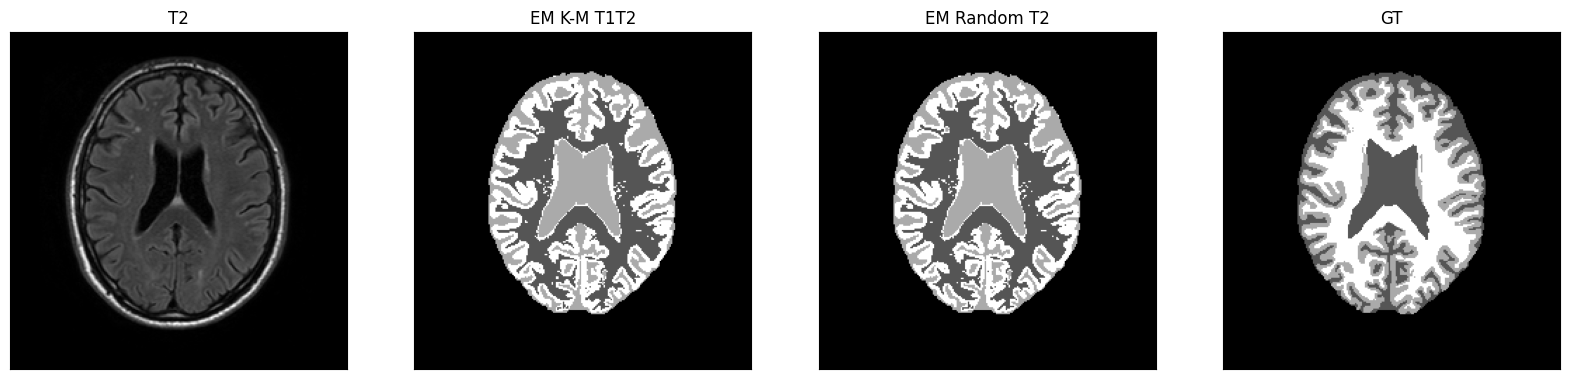

After matching areas


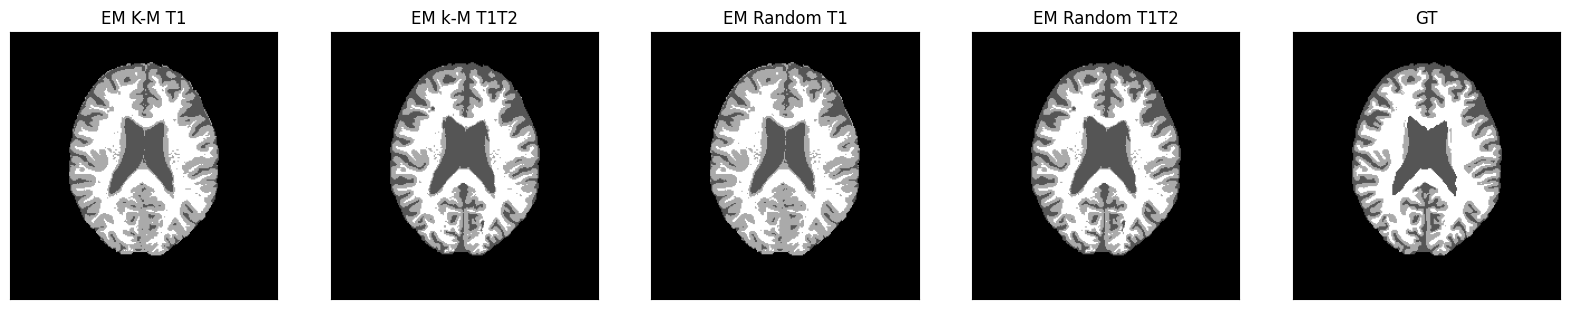

------------ Subject 1---------------------


 67%|██████▋   | 67/100 [00:14<00:07,  4.49it/s]


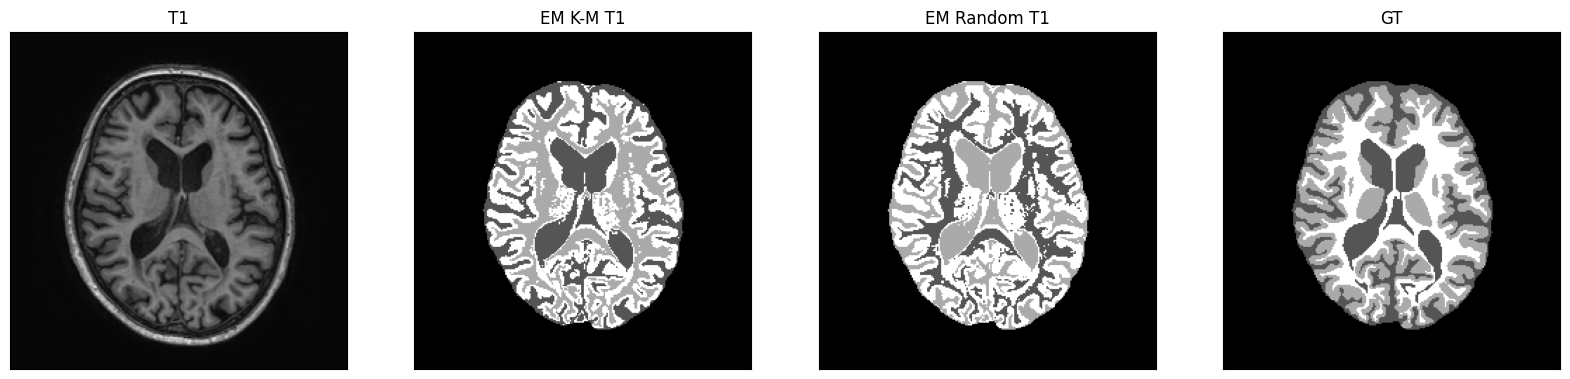

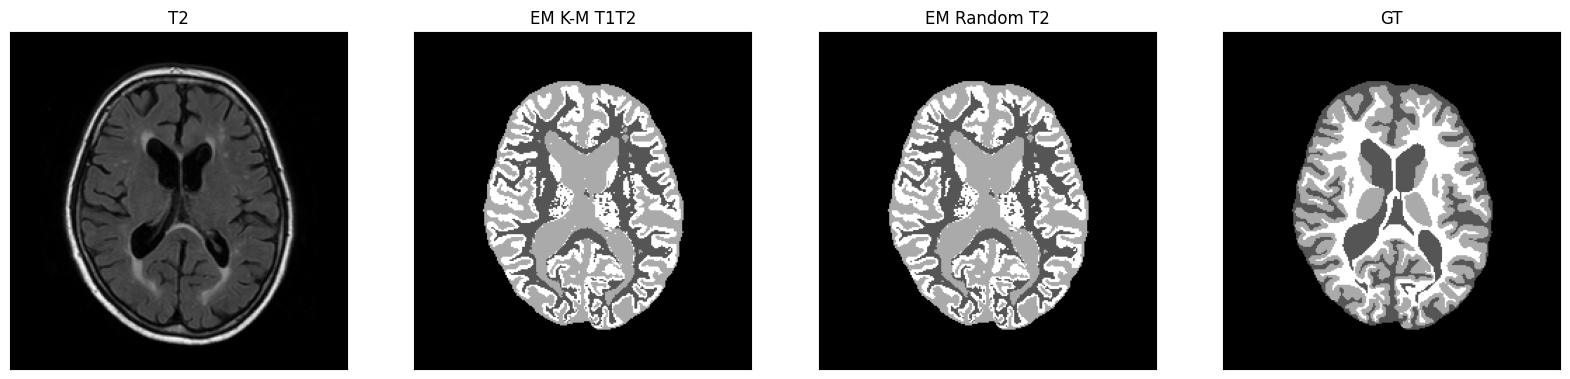

After matching areas


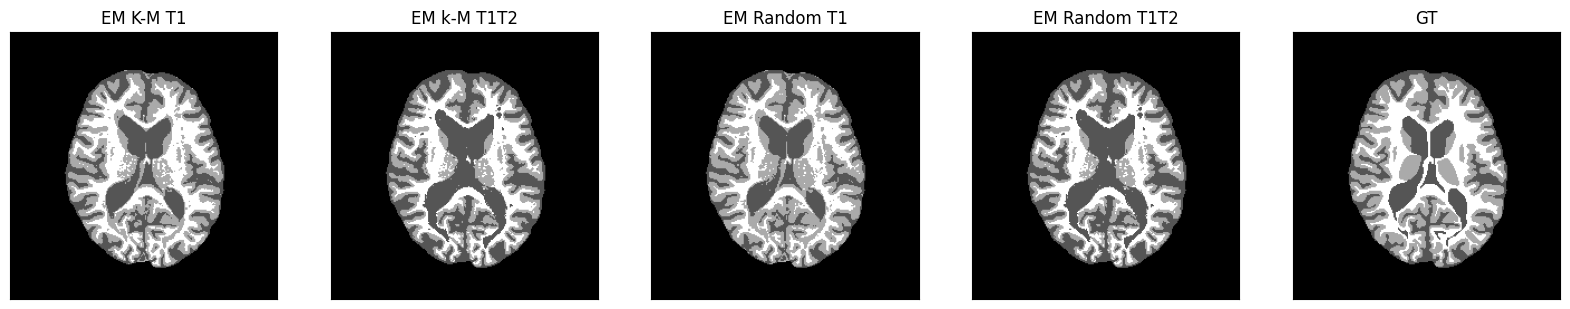

------------ Subject 2---------------------


 49%|████▉     | 49/100 [00:10<00:10,  4.66it/s]


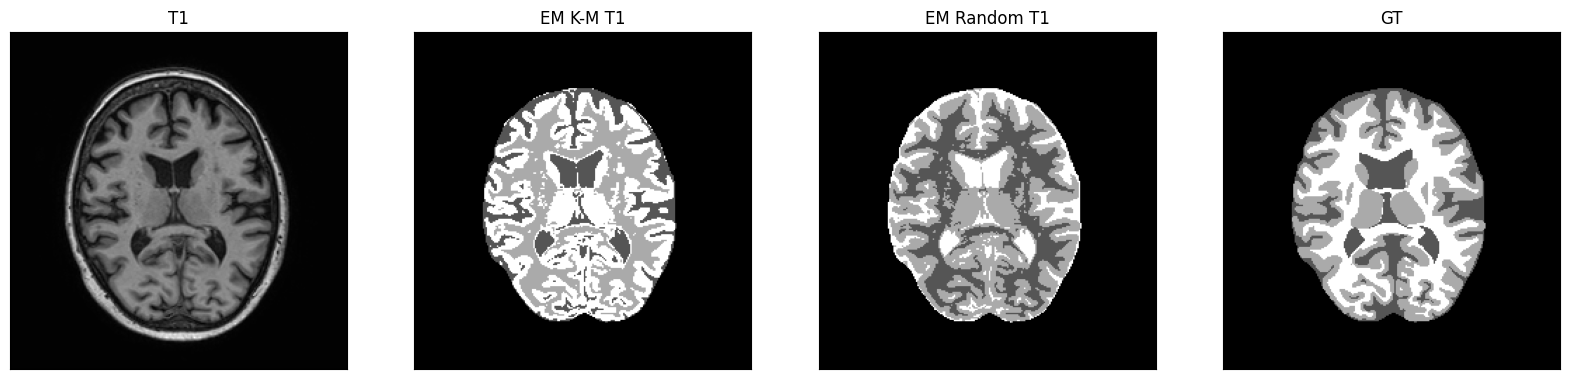

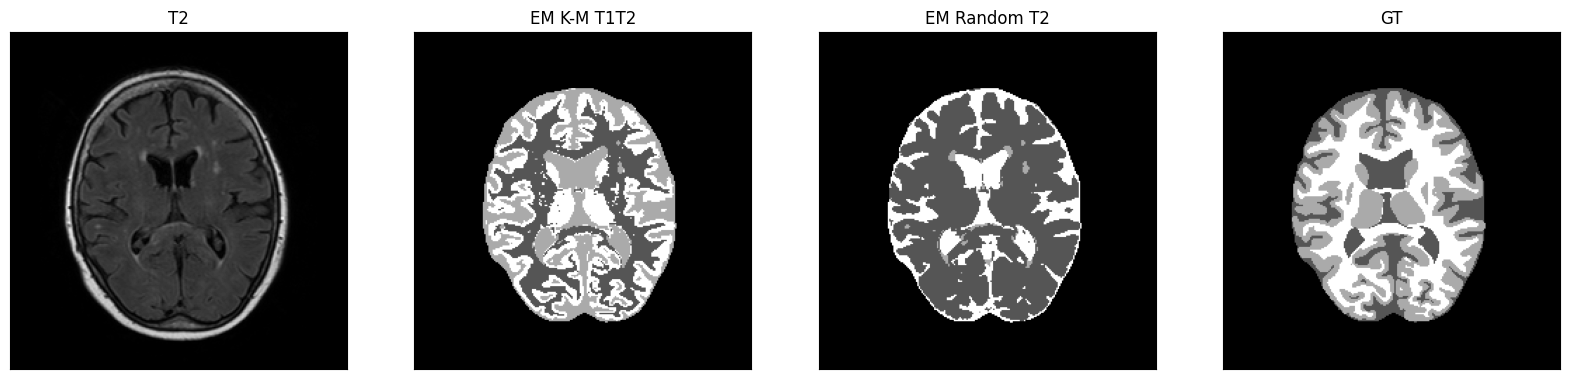

After matching areas


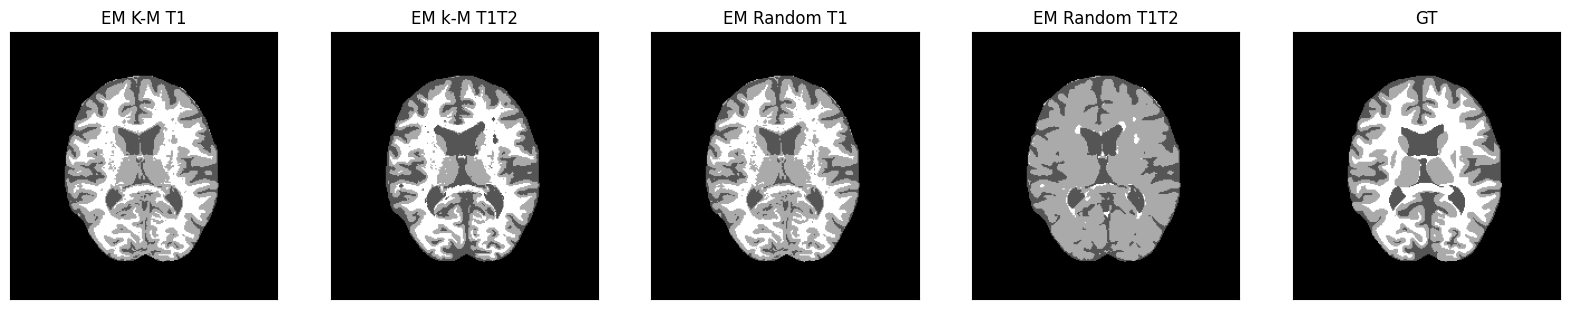

,CSF,GM,WM,modalities,subject,model,init,time
0,0.788816,0.776304,0.862269,T1,0,EM,kmeans_EM,8.600879
1,0.909933,0.826902,0.860474,T1+T2,0,EM,kmeans_EM,14.155247
2,0.737599,0.756388,0.858373,T1,0,EM,random,15.494102
3,0.909816,0.826915,0.862183,T1+T2,0,EM,random,15.494102
4,0.864053,0.788342,0.803055,T1,1,EM,kmeans_EM,6.069857
5,0.804464,0.745504,0.802635,T1+T2,1,EM,kmeans_EM,14.055142
6,0.863727,0.802710,0.787547,T1,1,EM,random,15.080797
7,0.804425,0.744742,0.802754,T1+T2,1,EM,random,15.080797
8,0.829275,0.786311,0.851740,T1,2,EM,kmeans_EM,8.711932
9,0.857337,0.778366,0.854924,T1+T2,2,EM,kmeans_EM,16.720068


In [4]:
t1_seg, t2_seg = [], []

results = []

for i in range(3):
    print(f'------------ Subject {i}---------------------')
    t1 = sitk.ReadImage(os.path.join('..','P2_Data',f'{i}','T1.nii'))
    t2 = sitk.ReadImage(os.path.join('..','P2_Data',f'{i}','T2_FLAIR.nii'))
    bm = sitk.ReadImage(os.path.join('..','P2_Data',f'{i}','brainMask.nii'))
    gth = sitk.ReadImage(os.path.join('..','P2_Data',f'{i}','LabelsForTesting.nii'))
    
    t1_array = sitk.GetArrayFromImage(t1)
    t2_array = sitk.GetArrayFromImage(t2)
    bm_array = sitk.GetArrayFromImage(bm)
    gth = sitk.GetArrayFromImage(gth)
    
    t1_s, t2_s,t1_s_t, t2_s_t = segmentation.get_tissue(t1_array,t2_array,bm_array)
    t1_s_r, t2_s_r,t1_s_r_t, t2_s_r_t = segmentation.get_tissue(t1_array,t2_array,bm_array,type='random')
    
    wm_t1, gm_t1, cfs_t1 = segmentation.match_pred_with_gt(t1_s,gth)
    wm_t2, gm_t2, cfs_t2 = segmentation.match_pred_with_gt(t2_s,gth)
    
    wm_t1_ms, gm_t1_ms, cfs_t1_ms = segmentation.match_pred_with_gt(t1_s_r,gth)
    wm_t2_ms, gm_t2_ms, cfs_t2_ms = segmentation.match_pred_with_gt(t2_s_r,gth)
    
    volumes = [t1_array,t1_s,t1_s_r,gth]
    names = ['T1','EM K-M T1','EM Random T1','GT']
        
    segmentation.plots(volumes,names)
    
    volumes = [t2_array,t2_s,t2_s_r,gth]
    names = ['T2','EM K-M T1T2','EM Random T2','GT']
    
    segmentation.plots(volumes,names)

    print('After matching areas')
    
    t1_s_m = wm_t1+gm_t1+cfs_t1
    t2_s_m = wm_t2+gm_t2+cfs_t2
    
    t1_s_ms_m = wm_t1_ms+gm_t1_ms+cfs_t1_ms
    t2_s_ms_m = wm_t2_ms+gm_t2_ms+cfs_t2_ms
    
    volumes = [t1_s_m,t2_s_m,t1_s_ms_m,t2_s_ms_m,gth]
    names = ['EM K-M T1','EM k-M T1T2','EM Random T1','EM Random T1T2','GT']
    
    segmentation.plots(volumes,names)
    
    
    results.append(segmentation.dice_score(gth,t1_s_m)+['T1', i, 'EM', 'kmeans_EM',t1_s_t])
    results.append(segmentation.dice_score(gth,t2_s_m)+['T1+T2', i, 'EM', 'kmeans_EM',t2_s_t])
    results.append(segmentation.dice_score(gth,t1_s_ms_m)+['T1', i, 'EM', 'random',t2_s_r_t])
    results.append(segmentation.dice_score(gth,t2_s_ms_m)+['T1+T2', i, 'EM', 'random',t2_s_r_t])

    
    


labels = ['CFS','GM','']  
labels = ['CSF', 'GM', 'WM', 'modalities', 'subject', 'model', 'init', 'time']
results = pd.DataFrame(data=results, columns=labels)
results.to_csv('dice_scores_init.csv')
results
 

In [5]:

df = pd.melt(results, id_vars=['modalities', 'subject', 'model', 'init', 'time'], value_vars=['CSF', 'GM', 'WM'], ignore_index=False)
df['model'] = df['model'].str.upper()
df.columns = ['Modalities', 'Subject', 'Model', 'Init', 'Time', 'Tissue', 'Dice']

df

,Modalities,Subject,Model,Init,Time,Tissue,Dice
0,T1,0,EM,kmeans_EM,8.600879,CSF,0.788816
1,T1+T2,0,EM,kmeans_EM,14.155247,CSF,0.909933
2,T1,0,EM,random,15.494102,CSF,0.737599
3,T1+T2,0,EM,random,15.494102,CSF,0.909816
4,T1,1,EM,kmeans_EM,6.069857,CSF,0.864053
5,T1+T2,1,EM,kmeans_EM,14.055142,CSF,0.804464
6,T1,1,EM,random,15.080797,CSF,0.863727
7,T1+T2,1,EM,random,15.080797,CSF,0.804425
8,T1,2,EM,kmeans_EM,8.711932,CSF,0.829275
9,T1+T2,2,EM,kmeans_EM,16.720068,CSF,0.857337


[Text(0.5, 1.0, 'Dice per Modality')]

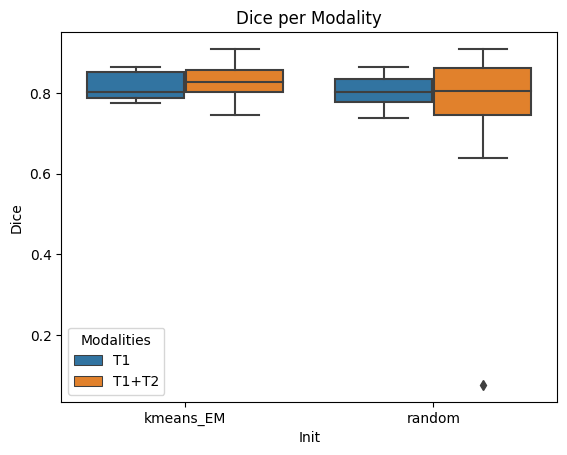

In [6]:
sns.boxplot(
    data=df, x="Init", y="Dice",hue="Modalities"
).set(title='Dice per Modality')

[Text(0.5, 1.0, 'Time per Modality')]

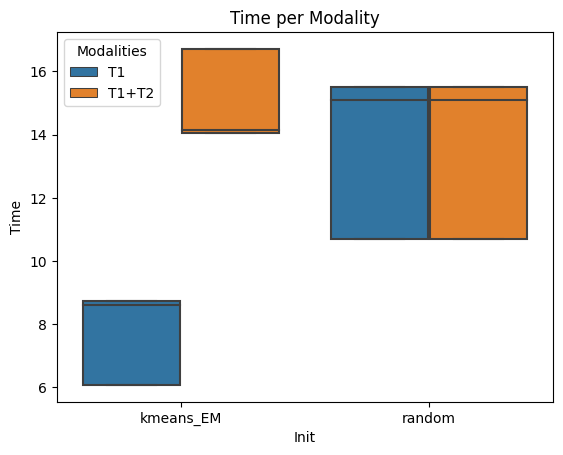

In [7]:
sns.boxplot(
    data=df, x="Init", y="Time",hue="Modalities"
).set(title="Time per Modality")

[Text(0.5, 1.0, 'Dice per Tissue with T1')]

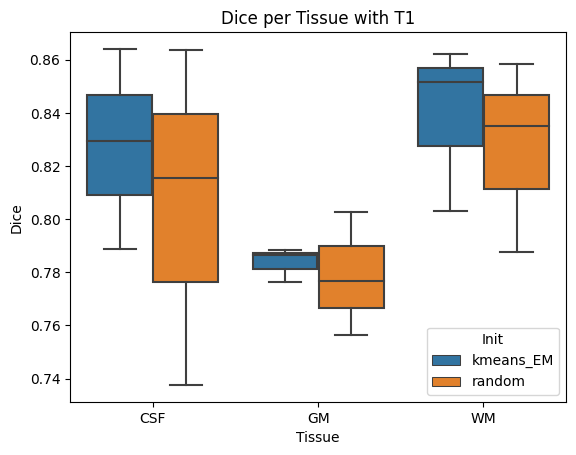

In [8]:
df_ = df.loc[df.Modalities == 'T1']
sns.boxplot(data=df_, x="Tissue", y="Dice", hue="Init").set(title="Dice per Tissue with T1")

[Text(0.5, 1.0, 'Dice per Tissue with T1+T2')]

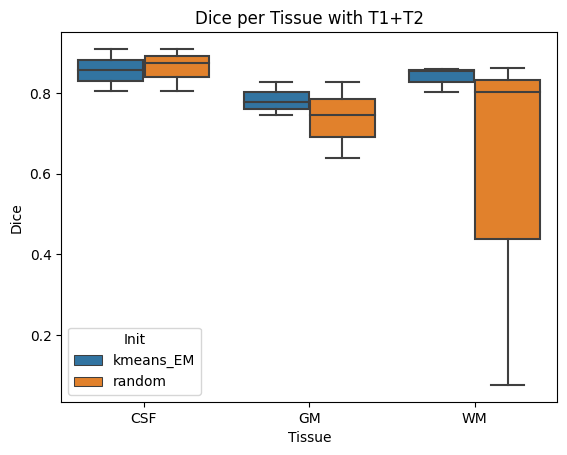

In [9]:
df_ = df.loc[df.Modalities == 'T1+T2']
sns.boxplot(data=df_, x="Tissue", y="Dice", hue="Init").set(title="Dice per Tissue with T1+T2")

In [10]:
results = []

for i in range(3):
    print(f'------------ Subject {i}---------------------')
    t1 = sitk.ReadImage(os.path.join('..','P2_Data',f'{i}','T1.nii'))
    t2 = sitk.ReadImage(os.path.join('..','P2_Data',f'{i}','T2_FLAIR.nii'))
    bm = sitk.ReadImage(os.path.join('..','P2_Data',f'{i}','brainMask.nii'))
    gth = sitk.ReadImage(os.path.join('..','P2_Data',f'{i}','LabelsForTesting.nii'))
    
    t1_array = sitk.GetArrayFromImage(t1)
    t2_array = sitk.GetArrayFromImage(t2)
    bm_array = sitk.GetArrayFromImage(bm)
    gth = sitk.GetArrayFromImage(gth)

    
    

------------ Subject 0---------------------
------------ Subject 1---------------------
------------ Subject 2---------------------
